<a href="https://colab.research.google.com/github/zzhining/financial_data_analysis/blob/main/stock_market_analysis_prediction_using_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Analysis

## 실습목표
----
주식 시장 데이터를 분석(pandas, 시각화)하고, 예측 알고리즘 생성(LSTM)

    1.) 시간에 따라 주가는 어떻게 변하는가?
    2.) 이동평균선
    3.) 일간 평균 수익률은 얼마인가?
    4.) 특정 종목은 다른 종목과 상관관계가 존재하는가?
    5.) 주가를 예측하기 위해서 어떤 특징(feature)을 사용할 수 있을까?
    6.) LSTM을 사용한 APPLE 종가 예측
   

## 0. 환경설정

In [1]:
pip install -U finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 4.3 MB/s eta 0:00:00


#### 1) 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data
import FinanceDataReader as fdr

# For time stamps
from datetime import datetime

#### 2) 데이터 불러오기
- globals(): 변수 명을 자동으로 생성하는 함수

In [3]:
# 분석할 종목 티커
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# 분석할 기간
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# 분석할 기간 동안의 데이터 읽어오기
for stock in tech_list:
    globals()[stock] = fdr.DataReader(stock, start = start, end = end)

In [4]:
AAPL.describe()

,Open,High,Low,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,199.117738,200.890199,197.409365,199.260079,5.828755e+07,198.890481
std,21.395569,21.582769,20.985076,21.329953,3.025434e+07,21.521087
min,165.350006,166.399994,164.080002,165.000000,2.404830e+07,164.585999
25%,182.547497,184.432503,181.424999,182.725002,4.278855e+07,182.144341
50%,192.695000,194.144997,191.570000,192.790001,5.174865e+07,192.223923
75%,221.635002,223.875004,219.197498,221.585003,6.478490e+07,221.392891
max,236.479996,237.490005,234.449997,236.479996,3.186799e+08,236.479996


In [5]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2023-11-01 to 2024-10-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Volume     252 non-null    int64  
 5   Adj Close  252 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


회사 별 데이터 프레임 합치기회사 이름 컬럼 추가

In [6]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Volume,Adj Close,company_name
2024-10-18,187.149994,190.740005,186.279999,188.990005,37417700,188.990005,AMAZON
2024-10-21,188.050003,189.460007,186.399994,189.070007,24639400,189.070007,AMAZON
2024-10-22,188.350006,191.520004,186.979996,189.699997,29650600,189.699997,AMAZON
2024-10-23,188.850006,189.160004,183.690002,184.710007,31937100,184.710007,AMAZON
2024-10-24,185.250000,187.110001,183.860001,186.380005,21647400,186.380005,AMAZON
2024-10-25,187.850006,190.449997,187.529999,187.830002,29362100,187.830002,AMAZON
2024-10-28,189.570007,190.210007,188.210007,188.389999,27930800,188.389999,AMAZON
2024-10-29,188.580002,191.460007,187.820007,190.830002,35690200,190.830002,AMAZON
2024-10-30,194.699997,195.610001,192.419998,192.729996,37707600,192.729996,AMAZON
2024-10-31,190.509995,190.600006,185.229996,186.399994,74225400,186.399994,AMAZON


## 1. 주가 변화
----

pandas를 사용해서 주가 데이터 탐색을 진행합니다.

#### 1) 최근 1년간 종가 시각화

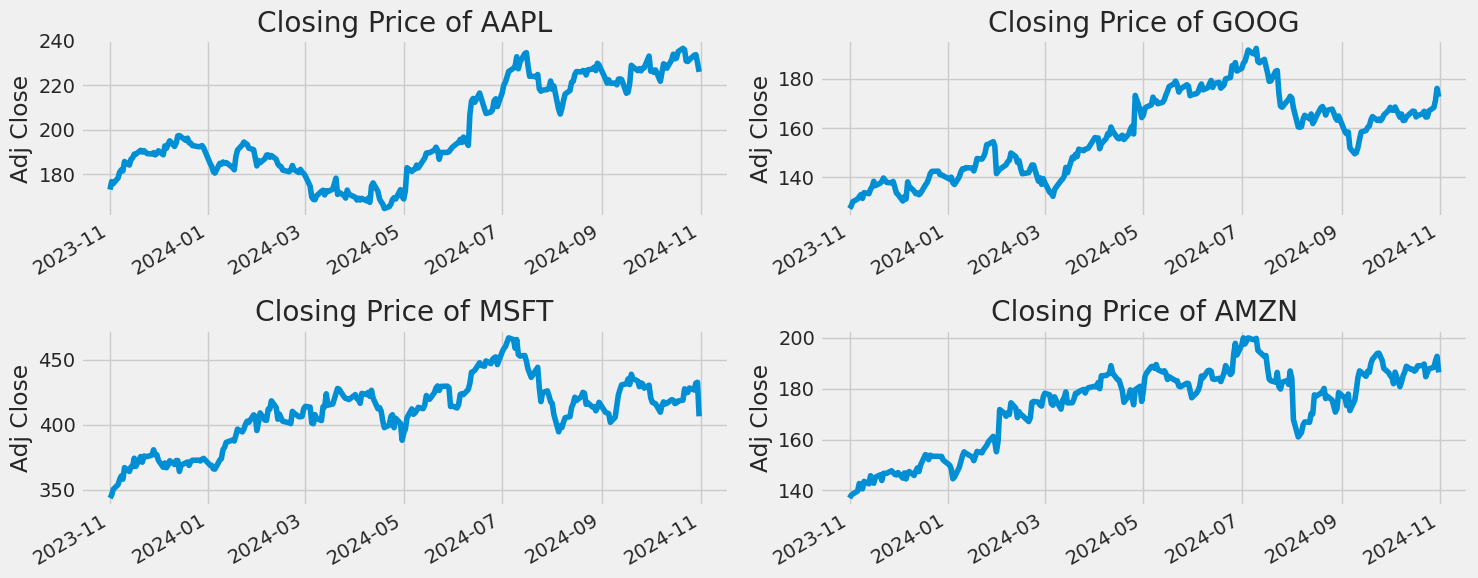

In [7]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

#### 2) 최근 1년간 거래량 시각화

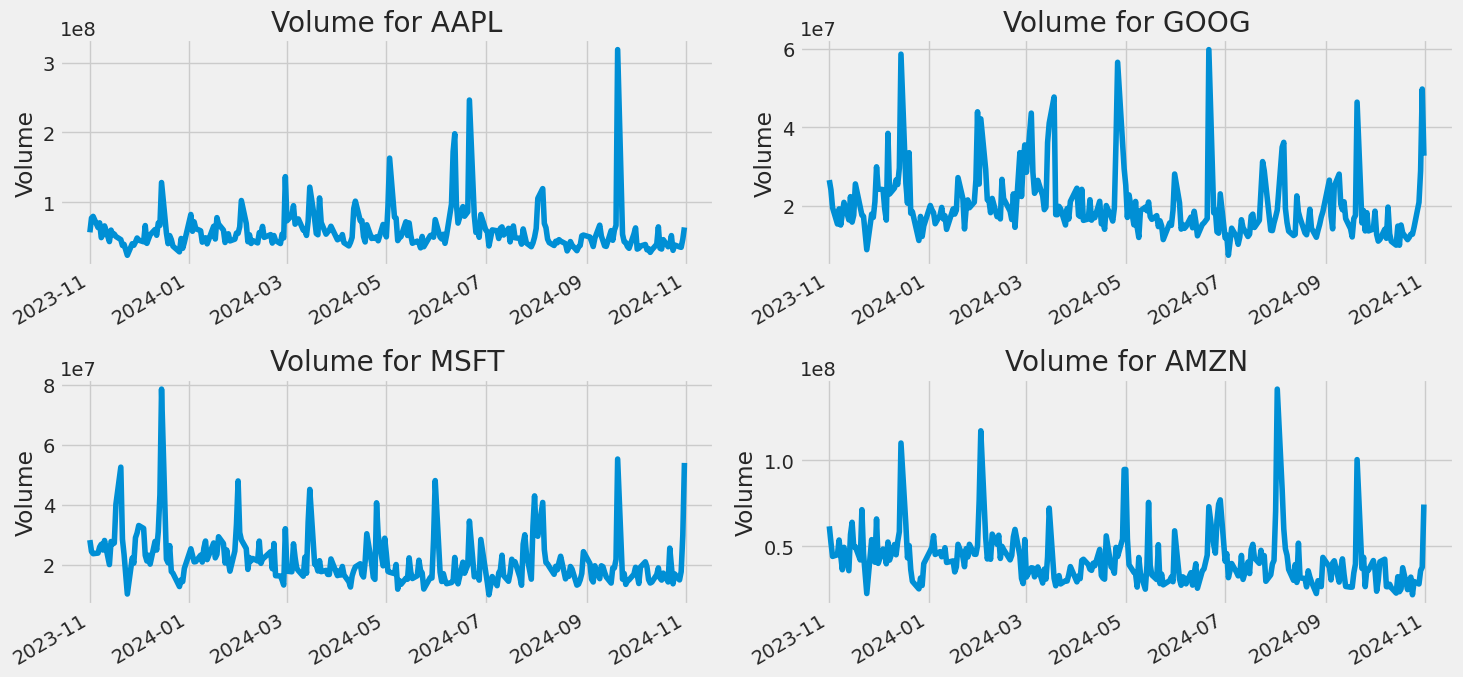

In [8]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 7))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Volume for {tech_list[i - 1]}")

plt.tight_layout()

## 2. 이동평균선(Moving Average)
---
10일, 20일, 50일 이동평균

In [9]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

10일, 20일, 50일 이동평균선

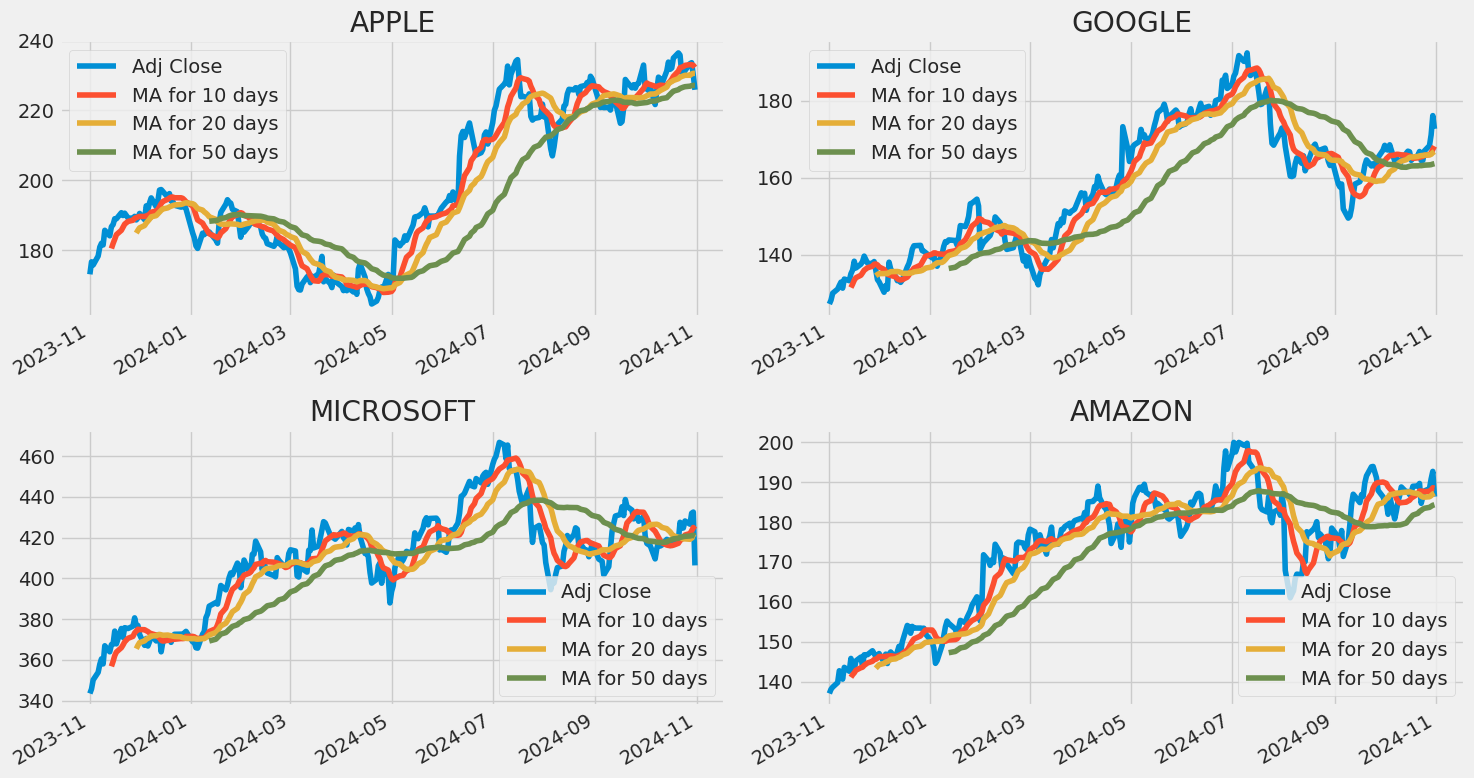

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

## 3. 일자별 수익률(Daily retrun)

일자 별 Daily return

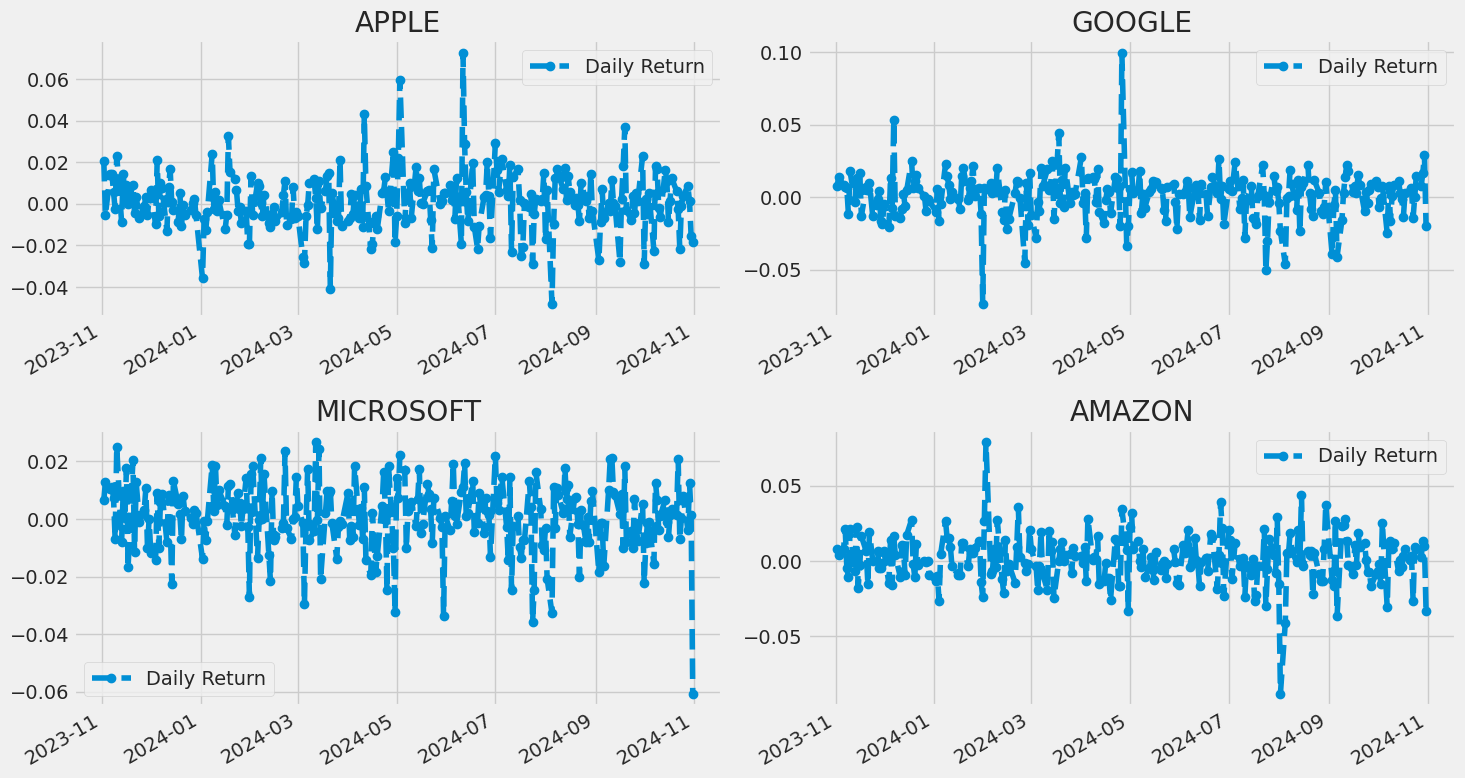

In [11]:
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

Daily return의 분포

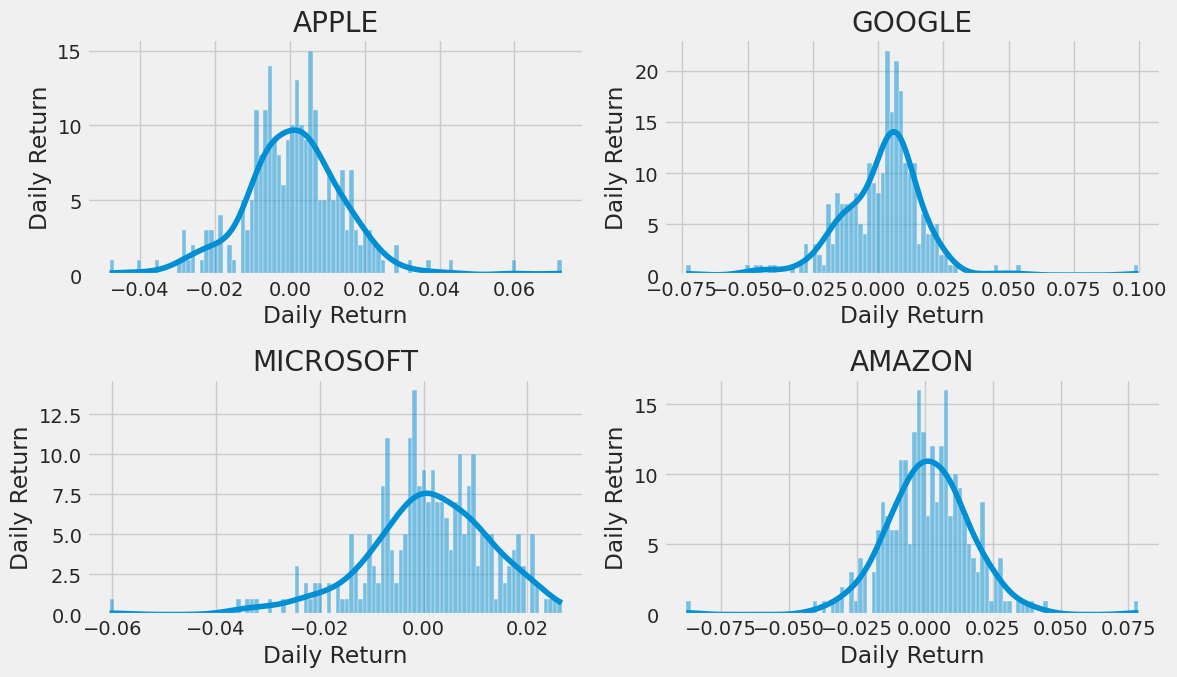

In [12]:
plt.figure(figsize=(12, 7))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    sns.histplot(company['Daily Return'].dropna(), kde = True, bins=100)#, color='purple')
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

## 4. 종목간 상관관계

종목 별 종가(`Adj Close`)기준 상관관계를 확인하기 위해 데이터프레임 생성

In [17]:
tech_list

['AAPL', 'GOOG', 'MSFT', 'AMZN']

In [23]:
closing_df = pd.DataFrame()
# 분석할 기간 동안의 데이터 읽어오기
for stock in tech_list:
    temp_df = fdr.DataReader(stock, start = start, end = end)['Adj Close']
    # 컬럼 이름을 stock으로 변경
    temp_df = temp_df.rename(stock)
    closing_df = pd.concat([closing_df, temp_df], axis=1)

closing_df.head()

,AAPL,GOOG,MSFT,AMZN
2023-11-01 00:00:00,173.084305,127.257477,343.491760,137.000000
2023-11-02 00:00:00,176.666000,128.265015,345.724945,138.070007
2023-11-03 00:00:00,175.750656,130.050613,350.171600,138.600006
2023-11-06 00:00:00,178.317520,131.127975,353.873810,139.740005
2023-11-07 00:00:00,180.894348,132.075638,357.844025,142.710007


Daily return

In [24]:
tech_rets = closing_df.pct_change()
tech_rets.head()

,AAPL,GOOG,MSFT,AMZN
2023-11-01 00:00:00,NaN,NaN,NaN,NaN
2023-11-02 00:00:00,0.020693,0.007917,0.006501,0.007810
2023-11-03 00:00:00,-0.005181,0.013921,0.012862,0.003839
2023-11-06 00:00:00,0.014605,0.008284,0.010573,0.008225
2023-11-07 00:00:00,0.014451,0.007227,0.011219,0.021254


#### 1) 종목별 종가의 Daily Return 상관관계 시각화

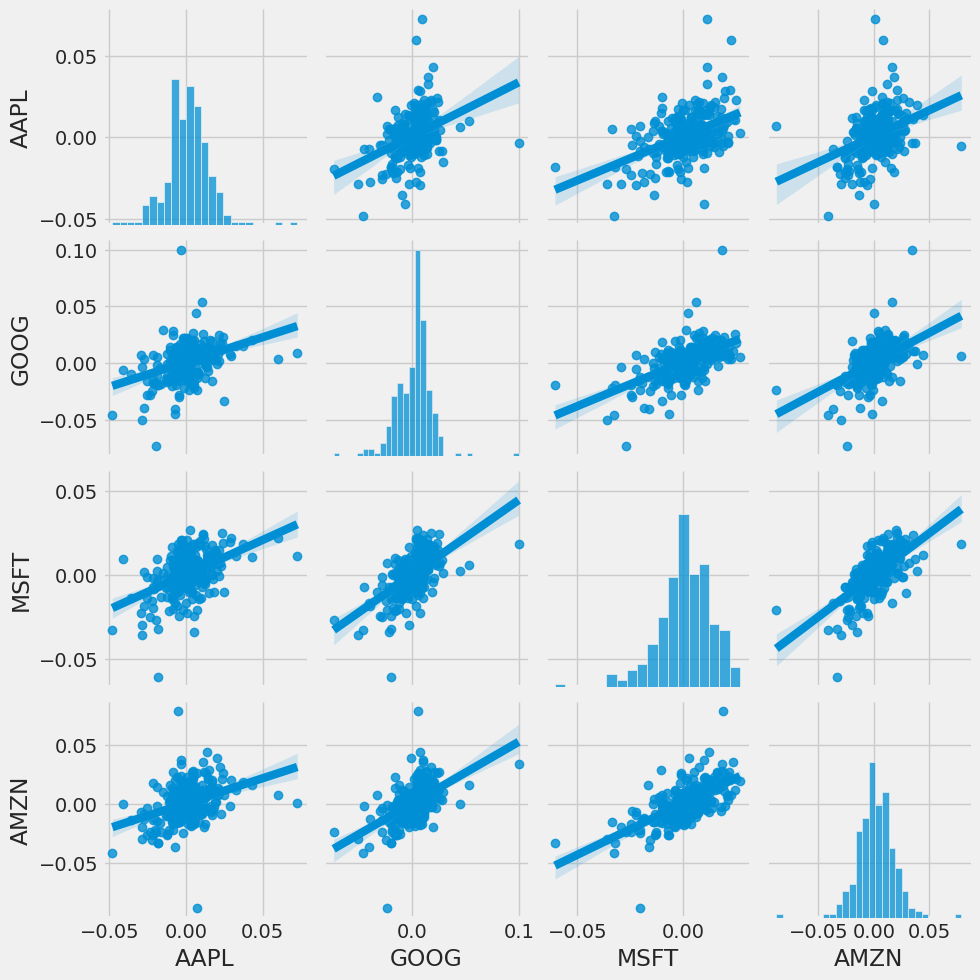

In [25]:
sns.pairplot(tech_rets, kind='reg')

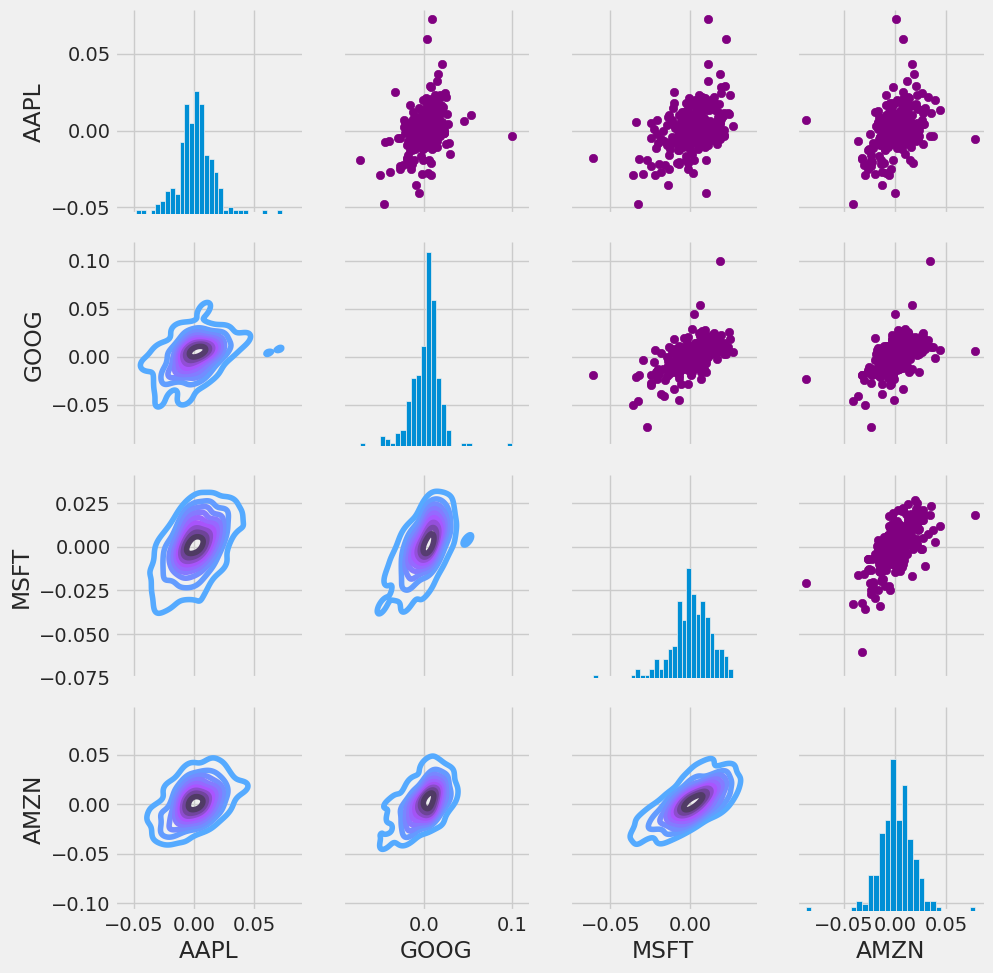

In [26]:
return_fig = sns.PairGrid(tech_rets.dropna())

# PairPlot의 상단부는 산점도
return_fig.map_upper(plt.scatter, color='purple')

# PairPlot의 하단부는 kde plot
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# PairPlot의 대각선은 히스토그램
return_fig.map_diag(plt.hist, bins=30)

#### 2) 종목별 종가의 상관관계 시각화

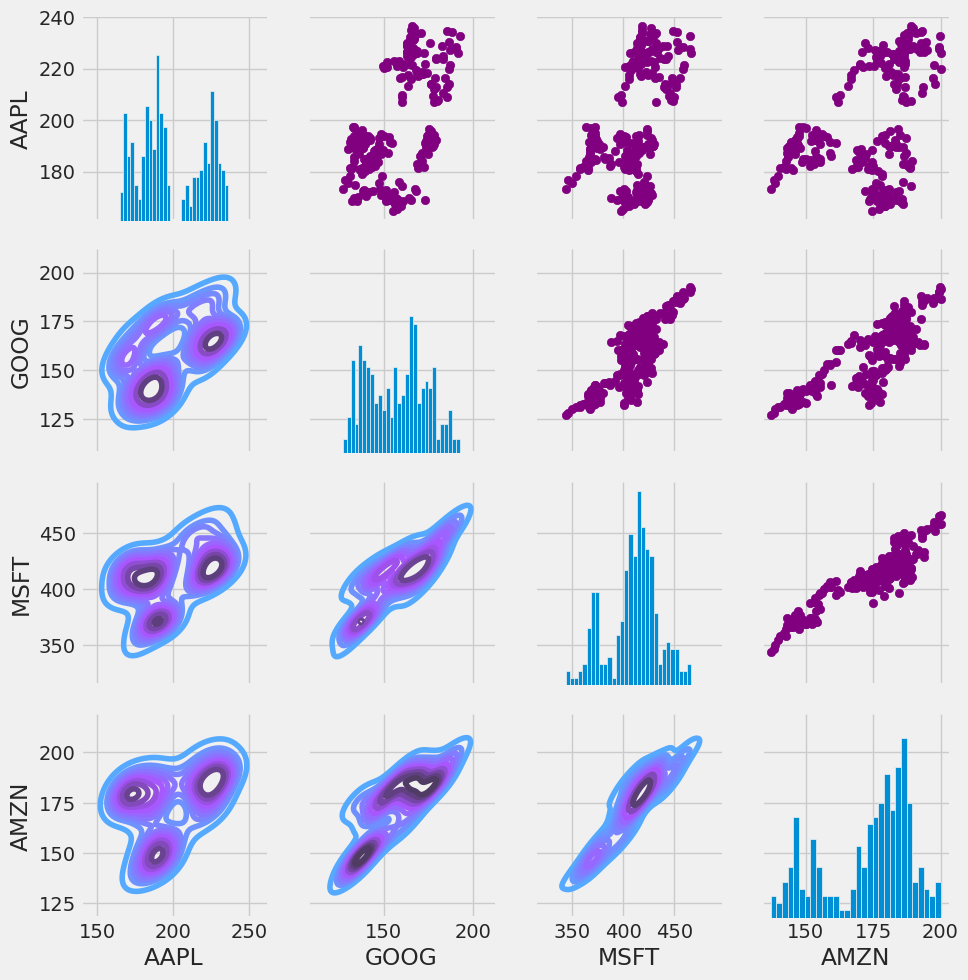

In [27]:
returns_fig = sns.PairGrid(closing_df)

returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

#### 3) 종목별 종가의 Daily Return 상관관계 시각화(Heatmap)

<Axes: >

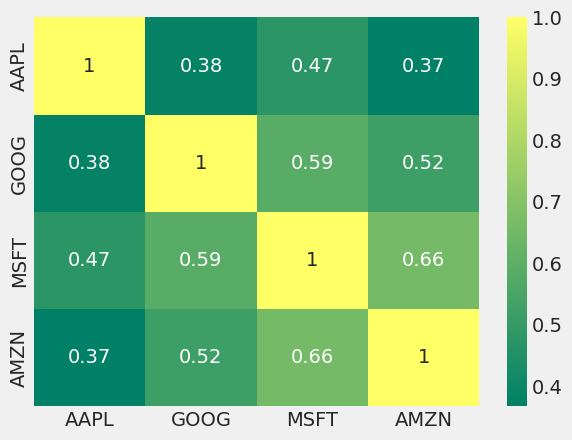

In [28]:
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')

#### 4) 종목별 종가의 상관관계 시각화(Heatmap)

<Axes: >

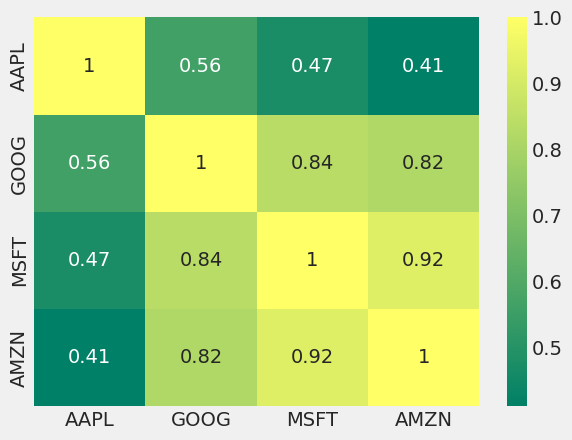

In [29]:
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')

모든 기술 회사가 양의 상관 관계를 갖고 있음

## 5. 기대수익률

기대수익률의 평균값과 표준편차 시각화

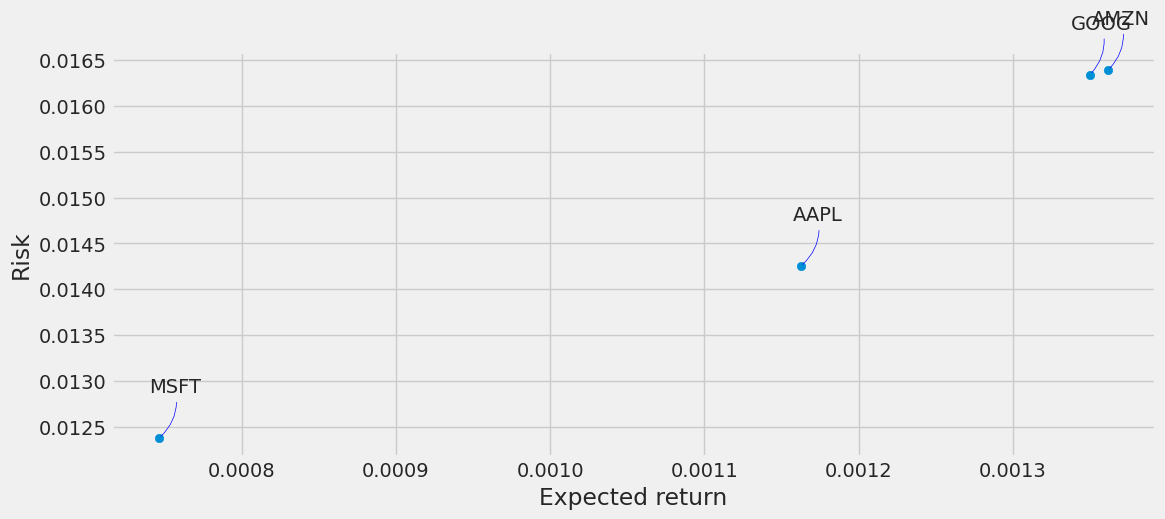

In [30]:
rets = tech_rets.dropna()

plt.figure(figsize=(12, 5))
plt.scatter(rets.mean(), rets.std())
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(30, 30), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

## 6. APPLE 주가 예측하기
----
최근 10년 동안의 APPLE 주가를 바탕으로 주가 예측

#### 1) 데이터 불러오기

In [33]:
df = fdr.DataReader('AAPL', start = '2012-01-01', end = end)
df.head()

,Open,High,Low,Close,Volume,Adj Close
2012-01-03,14.621429,14.732143,14.607143,14.686786,302220800,12.402628
2012-01-04,14.642857,14.810000,14.617143,14.765714,260022000,12.469282
2012-01-05,14.819643,14.948214,14.738214,14.929643,271269600,12.607716
2012-01-06,14.991786,15.098214,14.972143,15.085714,318292800,12.739511
2012-01-09,15.196429,15.276786,15.048214,15.061786,394024400,12.719305


#### 2) 데이터 탐색

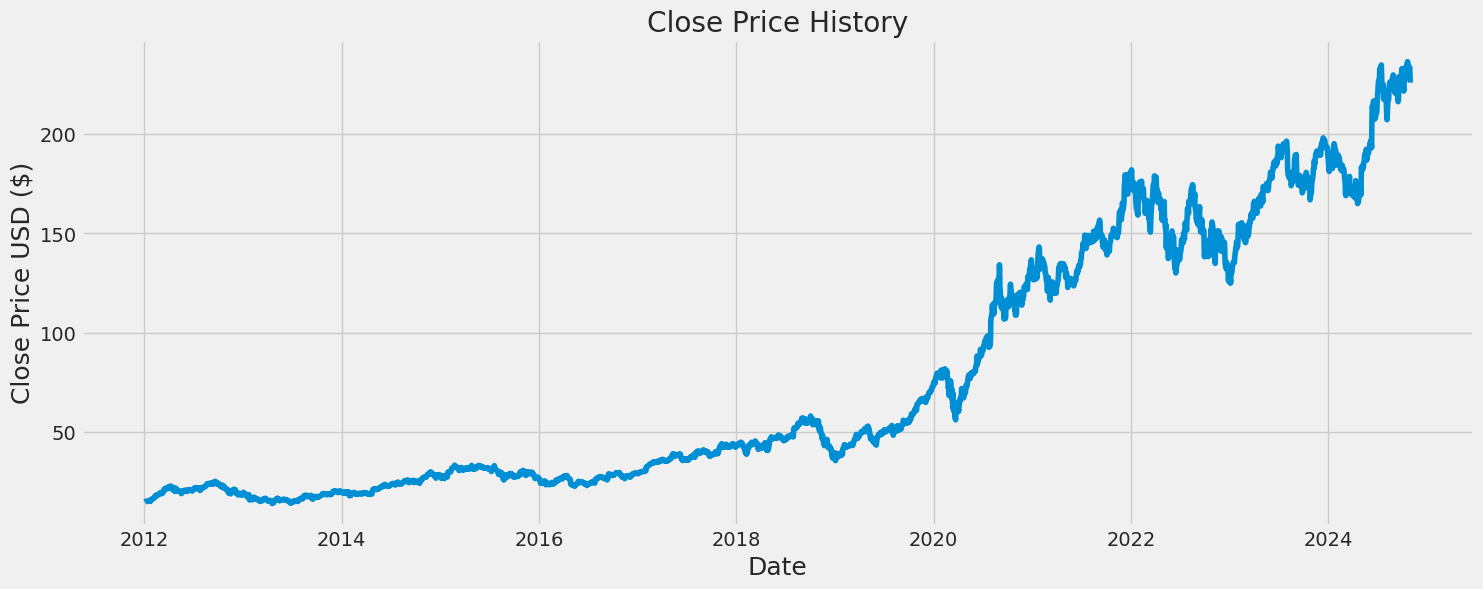

In [34]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

#### 3) 데이터 전처리 - Scale

In [35]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df.filter(['Close']).values)

scaled_data

array([[0.00332215],
       [0.00367683],
       [0.00441348],
       ...,
       [0.98737264],
       [0.97133008],
       [0.95250135]])

#### 4) 데이터 분할

In [36]:
# 전체 데이터 셋의 95%는 학습용으로 사용
training_data_len = int(np.ceil( len(scaled_data) * .95 ))
training_data_len

3068

In [37]:
train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[training_data_len - 60: , :]

x_train, y_train = [], []
x_test = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #[0:60]
    y_train.append(train_data[i, 0]) #[60]

# Create the data sets x_test and y_test
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

y_test = df.filter(['Close']).values[training_data_len:, :]

# Convert the x_train and y_train to numpy arrays
x_train, y_train, x_test = np.array(x_train), np.array(y_train), np.array(x_test)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [38]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3008, 60, 1), (3008,), (161, 60, 1), (161, 1))

#### 5) 학습 - 신경망(LSTM)

In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3008/3008 ━━━━━━━━━━━━━━━━━━━━ 166s 54ms/step - loss: 0.0019


#### 6) 예측

In [40]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


12.24702802217389

<ipython-input-41-427af188b99b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


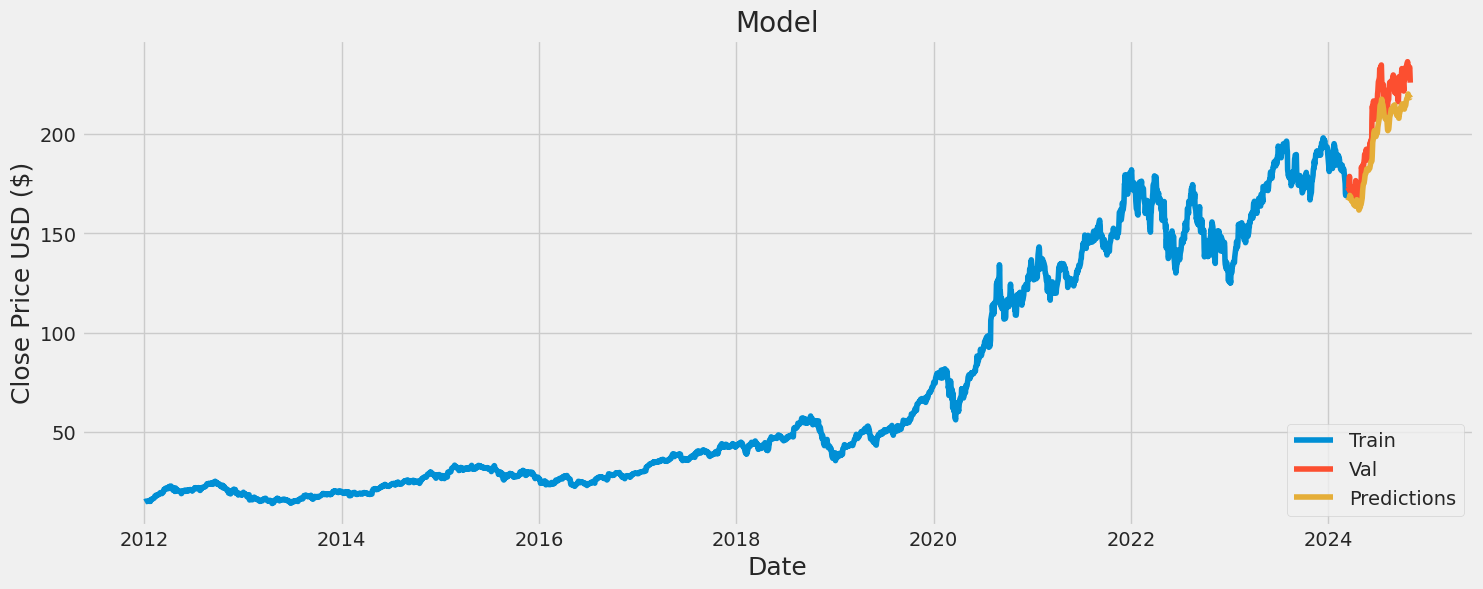

In [41]:
# Plot the data
data = df.filter(['Close'])
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [42]:
# Show the valid and predicted prices
valid

,Close,Predictions
2024-03-14,173.000000,166.527390
2024-03-15,172.619995,166.801544
2024-03-18,173.720001,166.992203
2024-03-19,176.080002,167.296844
2024-03-20,178.669998,167.990616
...,...,...
2024-10-25,231.410004,218.933624
2024-10-28,233.399994,218.356613
2024-10-29,233.669998,218.349472
2024-10-30,230.100006,218.600693


<ipython-input-43-4fee773dcfe1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['diff'] = valid['Close'] - valid['Predictions']


<Axes: xlabel='diff', ylabel='Count'>

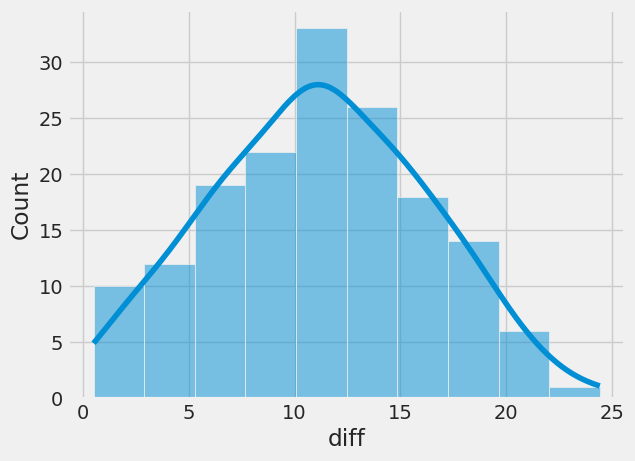

In [43]:
valid['diff'] = valid['Close'] - valid['Predictions']
sns.histplot(valid['diff'], kde=True)

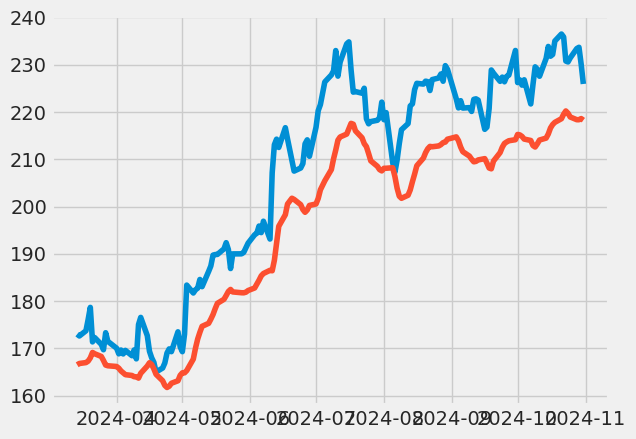

In [44]:
plt.plot(valid[['Close', 'Predictions']])